In [6]:
import h5py
folder = "/home/eric/tiny-differentiable-simulator/data/mit-push/abs_rect1/"
file = folder + "motion_surface=abs_shape=rect1_a=0_v=20_i=0.000_s=0.700_t=0.000_rep=0004.h5"

with h5py.File(file, "r") as f:
    print("Keys: %s" % f.keys())

    # Get the data
    object_poses = list(f["object_pose"])
    tip_poses = list(f["tip_pose"])

Keys: <KeysViewHDF5 ['ft_wrench', 'object_pose', 'tip_pose']>


(0.28975707945169926,
 0.3642556063056882,
 0.0018272558000162848,
 0.05053657980769665)

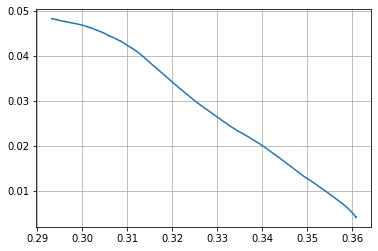

In [23]:
import matplotlib.pyplot as plt
import numpy as np

obj_poses_2d = np.array(object_poses)[:,1:3]
plt.plot(obj_poses_2d[:,0], obj_poses_2d[:,1])
plt.grid()
plt.axis('equal')

In [24]:
def visualize(filename):
    with h5py.File(filename, "r") as f:
        # Get the data
        object_poses = list(f["object_pose"])
        tip_poses = list(f["tip_pose"])
        obj_poses_2d = np.array(object_poses)[:,1:3]
        plt.plot(obj_poses_2d[:,0], obj_poses_2d[:,1])

(0.25856311199488596,
 0.5045409311447795,
 -0.12892365643878154,
 0.12031552872145565)

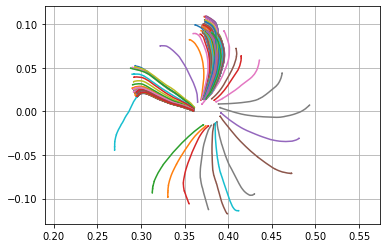

In [27]:
import glob
for file in glob.glob(folder + "*.h5"):
    visualize(file)
plt.grid()
plt.axis('equal')